# Hw 8(I think)
## Joshua Karten

Hey Professor Haule. 

This has been a wonderful class this semester. I have quite enjoyed the topics covered (though I would have loved to have more time for the advanced topics).

Thanks,

Josh

In [41]:
from numpy import *
from numpy import random
from numba import jit
from itertools import repeat
@jit(nopython=True)
def CEnergy(latt):
    "Energy of configuration for the 2D Ising model"
    N = shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]   # Spin, can be either +1 or -1
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.
    

def RandomL(N):
    "Random lattice corresponding to infinite temperature"
    return array(sign(2*random.random((N,N))-1),dtype=int) 

In [42]:
def PrepareEnergies(N):
    Energies = (array(4*arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist() # -2 N^2...2N^2 in steps of 4
    #Energies = range(-2*N*N,2*N*N,4)
    Energies.pop(1)  # take out E[1]
    Energies.pop(-2) # take out E[-2]
    Energies = array(Energies) # make array of energies again
    Emin, Emax = Energies[0],Energies[-1]
    #index array to energies
    indE = -ones(Emax+1-Emin, dtype=int) # index table to get index to particular energy g(E)~g[indE[E]]
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    # Ising lattice at infinite T
    ## g(E) we know E = -2*N^2,2*N^2 in steps of 4...
    return (Energies, indE, Emin)
def WangLandau(Nitt, N, flatness):  
    "Wang Landau in Python"
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)
    return RunWangLandau(Nitt,Energies,latt,indE,flatness)
@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE,flatness):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    #min,maximum energy
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = zeros(len(Energies))
    # Histogram
    Hist = zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) # the energy change if we flip the spin
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]] # log(g(Enew))
        lgold = lngE[indE[Ene-Emin]]  # log(g(Eold))
        P = 1.0
        if lgold-lgnew < 0 : P=exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf   # g(E) -> g(E)*f hence log(g(E)) -> log(g(E))+log(f)
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', exp(lnf))
    return (lngE, Hist)

def Thermod(T, lngE, Energies, N):
    Z = 0.
    Ev = 0.  # <E>
    E2v = 0. # <E^2>
    # <E^n> = sum_E e^(-E/T)*g[E] E^n /Z
    # Zw = Z/Z_0
    # <E^n> = Z0/Z sum_E e^(-(E-Emin)/T) g[E]/g[0] E^N
    for i,E in enumerate(Energies):
        # Z += exp(log(g)) * exp(-E/T)
        # Z/Z_0 = w where Z_0 = g[0] exp(-Energies[0]/T)
        w = exp(lngE[i]-lngE[0]-(E-Energies[0])/T) # g(E)/g0 Exp(-(E-E0)/T)
        Z += w
        Ev += w*E
        E2v += w*E**2
    Ev *= 1./Z
    E2v *= 1./Z
    cv = (E2v-Ev**2)/T**2
    # Z_correct = Z * exp(lngE[0]-Energies[0]/T)
    # Entropy = log(Z_correct) + <E>/T = log(Z) + lngE[0]-Energies[0]/T + Ev/T
    Entropy = log(Z)+lngE[0]+Ev/T-Energies[0]/T
    return (Ev/(N**2), cv/(N**2), Entropy/(N**2))

In [43]:
gexact= array([2,2048,4096,1057792,4218880,371621888,2191790080,100903637504,768629792768,22748079183872])


In [44]:
Nitt = int(1e9)
Te = linspace(0.5,4.,300)
N=32
(Energies, indE, Emin) = PrepareEnergies(N)
lngE=[]
Hist=[]
for i in range(5):
    lE,H=WangLandau(Nitt,N,0.9)
    lngE.append(lE)
    Hist.append(H)
    

75459999 histogram is flat 66349.0 73691.40625 f= 1.6487212707001282
87560999 histogram is flat 10643.0 11817.3828125 f= 1.2840254166877414
103816999 histogram is flat 14298.0 15875.0 f= 1.1331484530668263
122027999 histogram is flat 16008.0 17784.1796875 f= 1.0644944589178593
134484999 histogram is flat 10953.0 12165.0390625 f= 1.0317434074991028
149003999 histogram is flat 12763.0 14178.7109375 f= 1.0157477085866857
163700999 histogram is flat 12932.0 14352.5390625 f= 1.007843097206448
181938999 histogram is flat 16083.0 17810.546875 f= 1.0039138893383475
198102999 histogram is flat 14207.0 15785.15625 f= 1.0019550335910028
221754999 histogram is flat 20826.0 23097.65625 f= 1.0009770394924165
262059999 histogram is flat 35471.0 39360.3515625 f= 1.0004884004786945
316295999 histogram is flat 47670.0 52964.84375 f= 1.0002441704297478
376086999 histogram is flat 52604.0 58389.6484375 f= 1.0001220777633837
496508999 histogram is flat 105965.0 117599.609375 f= 1.0000610370189331
702868999

In [45]:
lngE=array(lngE)
Hist=array(Hist)
print(lngE.shape,Hist.shape)

(5, 1023) (5, 1023)


In [46]:
safeE=lngE
safeH=Hist


In [47]:
for i in range(5):
    if lngE[i,-1]>lngE[i,0]:
        lgC = log(4)-lngE[i,-1]-log(1+exp(lngE[i,0]-lngE[i,-1]))
    else:
        lgC = log(4)-lngE[i,0]-log(1+exp(lngE[i,-1]-lngE[i,0]))

    lngE[i] += lgC

Text(0.5, 1.0, 'Density of States Computed using Wang-Landau')

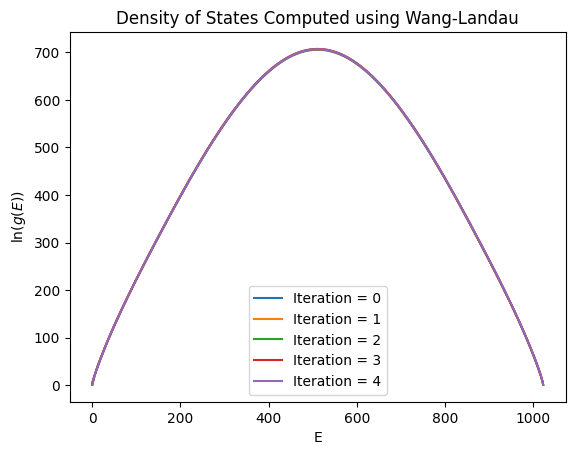

In [48]:
from pylab import *
%matplotlib inline
fig,ax = plt.subplots()
for i in range(5):
    plot(lngE[i],label='Iteration = '+str(i))
ax.set_xlabel('E')
legend()
ax.set_ylabel(r'$\ln(g(E))$')
ax.set_title('Density of States Computed using Wang-Landau')


This is a sucessfull replication of the results from the algorithm run in class. All 5 iterations report identical results.

Text(0.5, 1.0, 'Difference Between Computed and Exact values of S(E) for E$<$10')

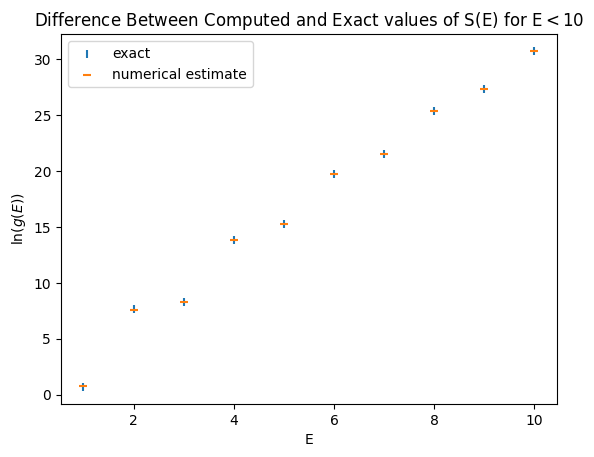

In [58]:
fig,ax=subplots()
scatter([1,2,3,4,5,6,7,8,9,10],log(gexact),marker='|',label='exact')
scatter(list(range(1,11)),lngE[0,:10],marker='_',label='numerical estimate')
legend()
ax.set_xlabel('E')
ax.set_ylabel(r'$\ln(g(E))$')
ax.set_title(r'Difference Between Computed and Exact values of S(E) for E$<$10')

In [50]:
avE = average(lngE,axis=0)
stdE = std(lngE,axis=0,ddof=1)

Text(0.5, 1.0, 'Difference Between Computed Average and Exact values of S(E) for E$<$10')

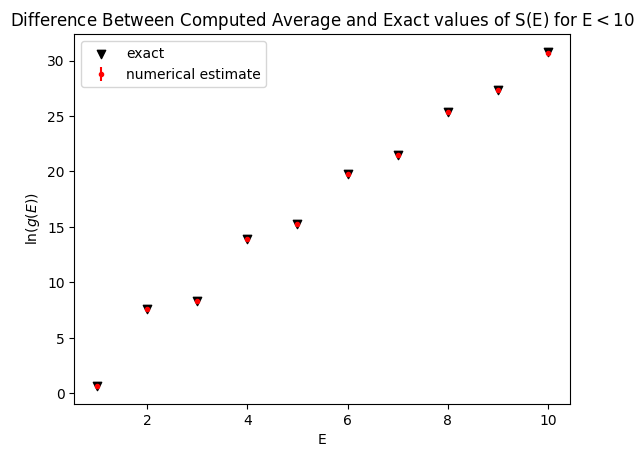

In [51]:
fig,ax=subplots()

scatter([1,2,3,4,5,6,7,8,9,10],log(gexact),marker='v',color='black',label='exact')
errorbar(list(range(1,11)),avE[:10],yerr=stdE[:10],marker='.',color='red',linestyle='None',label='numerical estimate')
legend()
ax.set_xlabel('E')
ax.set_ylabel(r'$\ln(g(E))$')
ax.set_title(r'Difference Between Computed Average and Exact values of S(E) for E$<$10')

Text(0.5, 1.0, 'Error in Computed Average of S(E) for E$<$10')

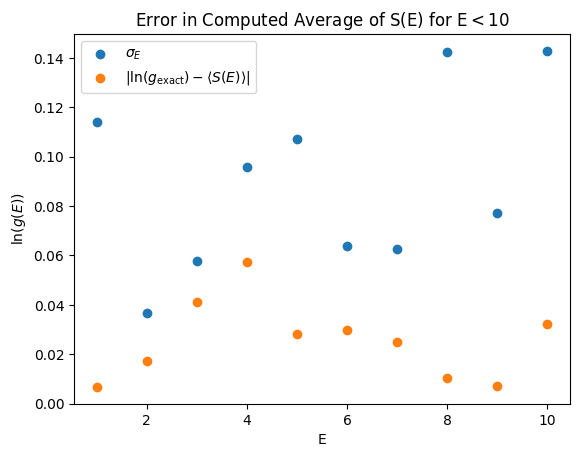

In [52]:
fig,ax=plt.subplots()
scatter(list(range(1,11)),stdE[:10],label=r'$\sigma_E$')
scatter(list(range(1,11)),abs(log(gexact)-avE[:10]),label=r'$|\ln(g_{\text{exact}})-\langle S(E) \rangle|$')
legend()
ax.set_xlabel('E')
ax.set_ylabel(r'$\ln(g(E))$')
ax.set_title(r'Error in Computed Average of S(E) for E$<$10')

This seems to be a very accurate algorithm. The biggest contributor to the error is likely the number of iterations as 5 is so few. 

There is very little difference between the exact value and our calculated value, as seen above. In fact, it is often less than $\sigma_E$ by a factor of 5.

Text(0.5, 1.0, 'Difference Between Computed and Average Computed values of S(E)')

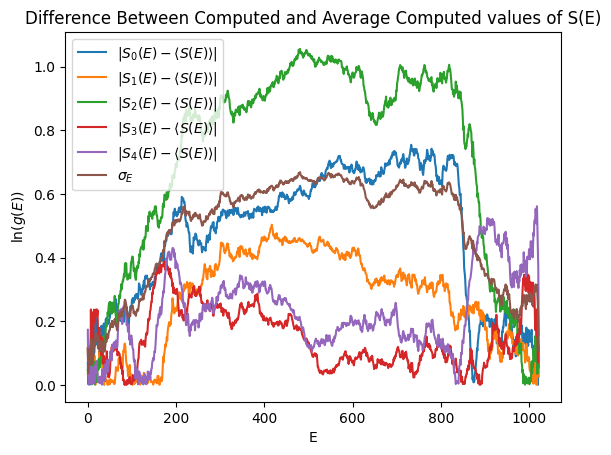

In [53]:
fig,ax=plt.subplots()
for i in range(5):
    plot(abs(lngE[i]-avE),label=r'$|S_{%5.1i}(E) - \langle S(E)\rangle|$'% i)
plot(stdE,label=r'$\sigma_E$')
legend()
ax.set_xlabel('E')
ax.set_ylabel(r'$\ln(g(E))$')
ax.set_title(r'Difference Between Computed and Average Computed values of S(E)')

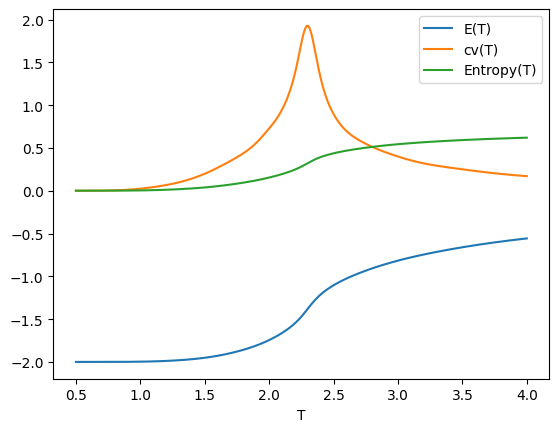

Text(0.5, 1.0, 'Thermodynamics of the Average Computed Value of S(E)')

In [54]:
(Energies, indE, Emin) = PrepareEnergies(N)

Te = linspace(0.5,4.,300)

Thm=[]
for T in Te:
    Thm.append(Thermod(T, avE, Energies, N))
Thm = array(Thm)



from pylab import *
%matplotlib inline
fig,ax=plt.subplots()
plot(Te, Thm[:,0], label='E(T)')
plot(Te, Thm[:,1], label='cv(T)')
plot(Te, Thm[:,2], label='Entropy(T)')
xlabel('T')
legend(loc='best')
show()

ax.set_xlabel('Temperature')
ax.set_ylabel('Parameter Values')
ax.set_title('Thermodynamics of the Average Computed Value of S(E)')

In [55]:
print('Entropy(T=%5.3f)=%8.6f Entropy(T=%5.3f)=%5.3f * log(2)' % (Te[0],Thm[0,2],Te[-1],Thm[-1,2]/log(2)))

Entropy(T=0.500)=0.000672 Entropy(T=4.000)=0.894 * log(2)


There is very little change in the thermodynamics of the system when using 1 simulation (as done in class) and when averaging over 5 simulations. The main thing is that the peak of cv is more centered than in the class notebook.
